(02-uncertainty)=
# Conceptual Tools for Handling Uncertainty


This book is focused on applications, so in this chapter we present a framing of uncertainty that is chosen to help you make decisions. The concepts here aim to describe uncertainty as *non-overlapping* types and to make suggestions about how to handle each type of uncertainty. In this way, we intend to provide you with tools to handle uncertainty.

**Learning Objectives** In this chapter, you will learn

- the distinction between *parametric* and *model-form nature*,
- the distinction between *chance* and *assignable causes*,
- the distinction between *real* and *erroneous sources*,
- some special cases of uncertainty: *variability* and *sampling*, and
- examples of these concepts in short case studies.


In [1]:
# Cell removed
import grama as gr
import numpy as np
import pandas as pd

DF = gr.Intention()
gr.hide_traceback()
%matplotlib inline
gr.set_uqtheme()

from myst_nb import glue

## Uncertainty Definitions
```{index} single: uncertainty
```

Let's start with a definition of uncertainty:

Uncertainty
: *Uncertainty* refers to any lack of perfect knowledge.

Given this definition, almost *everything* is uncertain! Our knowledge is always imperfect in a variety of ways: rounding in floating point calculations leads to a loss of precision, experimental noise corrupts our measurements, and the lack of a theory marrying quantum mechanics and relativity reflects our imperfect knowledge of physics. 

To make our understanding of uncertainty more useful, we will introduce three dichotomies to describe various kinds of uncertainty: the *nature*, *cause*, and *source* of uncertainty.


### Dichotomy: Parametric vs. model-form nature
```{index} single: uncertainty ; nature
```

It is common to distinguish between uncertainties in a quantity and in the form of equations {cite}`smith2013uncertainty,morgan2017theory,cullen1999probabilistic`. We will call these the *parametric and model-form natures* of uncertainty.

```{index} seealso: parametric uncertainty ; uncertainty ; nature
```

Parametric uncertainty
: Uncertainty that is **parametric** in nature concerns the *value* (numeric, categorical, etc.) of a quantity.

Parametric uncertainty can arise in many situations, such as the coefficients entering into a physical model, the stiffness of a manufactured part, or the range of a ballistic projectile. As noted in the definition, the quantity of interest can take numerical values (such as a material property), categorical values (such as True or False), or some other more complicated form (such as a description of the surface finish of a material).


```{index} seealso: model-form uncertainty ; uncertainty ; nature
```

Model-form uncertainty
: Uncertainty that is **model-form** in nature concerns the *data-generating process* under study.

Model-form uncertainty often manifests as uncertainty in the structure of the mathematical equations that comprise the model. As a simple example, we might be deciding between two qualitatively different models $f_1(x) = a x^1$ or $f_3(x) = c x^3$. The same example illustrates how model-form uncertainty can affect parametric uncertainty: The quantities in a model depend on its functional form. Whether we are discussing uncertainty in $a$ or $c$ is conditional on the form of the model we choose, which itself may be uncertain.

Note that we use the word "model" to refer to both the description of the inputs (bounds and distribution) and the functions mapping inputs to outputs. Thus, model-form uncertainty can enter into both the mathematical description of the problem that maps inputs to outputs and the distributions we use to describe input uncertainty. 

Model-form uncertainty can also emerge when assumptions or simplifications lead to the exclusion of important processes or subsystems. One way this can occur is when important variables are left out of your model, sometimes called *lurking variables* {cite}`delRosario2019lurking,joiner1981,box1966`.

```{hint} **Natures of uncertainty in trajectory prediction.**
Uncertainties of both natures arise in predicting the trajectory of a projectile (see {numref}`Appendix %s <04s-trajectory>`). A simple linear relationship (between the drag force and the projectile's velocity) has model-form uncertainty, as true drag behavior is far more complex. The initial velocity of the projectile may not be precisely known, which would be a parametric uncertainty.
```

```{index} single: bias
```
```{index} seealso: bias ; model-form uncertainty
```

The related term **model-form error** refers to cases when a model *systematically* produces incorrect predictions. **{numref}`Figure %s <fig-unc-vis-bias>`** provides a schematic view of two cases, both with and without systematic errors---also called *biased* and *unbiased*.

Even in the unbiased case, we would not expect a model to make perfect predictions all the time. This could be due to parametric uncertainty in the model, or due to irreducible *variability* in the data-generating process

In the biased case, the model will tend to give incorrect predictions that cannot be accounted for entirely by parametric uncertainty or variability. In this case, the model has some *model-form error* which prevents accurate representation of the data-generating process.


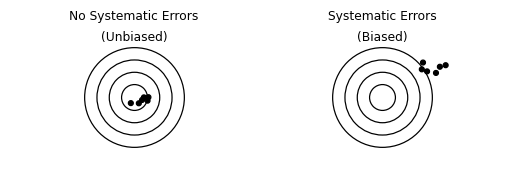

In [2]:
%%capture --no-display
p = (
    gr.df_make(
        x=gr.marg_mom("norm", mean=0, sd=0.2).r(6),
        y=gr.marg_mom("norm", mean=0, sd=0.2).r(6),
        source="No Systematic Errors\n(Unbiased)"
    )
    >> gr.tf_bind_rows(
        gr.df_make(
            x=gr.marg_mom("norm", mean=1, sd=0.2).r(6),
            y=gr.marg_mom("norm", mean=1, sd=0.2).r(6),
            source="Systematic Errors\n(Biased)"
        )
    )
    
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.annotate("point", x=0, y=0, color="black", fill="white", size=40)
    + gr.annotate("point", x=0, y=0, color="black", fill="white", size=30)
    + gr.annotate("point", x=0, y=0, color="black", fill="white", size=20)
    + gr.annotate("point", x=0, y=0, color="black", fill="white", size=10)
    + gr.geom_point()
    + gr.facet_grid("~source")
    + gr.coord_cartesian(xlim=(-2, +2), ylim=(-2, +2))
    + gr.theme_void()
    + gr.theme(aspect_ratio=1/2, plot_background=gr.element_rect(fill="white"))
)
print(p)

```{glue:figure} unc-vis-bias
:name: fig-unc-vis-bias

Schematic depiction of systematic errors (bias). In the left panel (unbiased), all observations tend to land near their target. In the right panel (biased), all observations tend to land off-center.
```

```{tip} **Parametric or model-form in nature?**
Determining whether an uncertainty is parametric or model-form in nature helps you determine "where" the uncertainty is in your model---and what actions you should take. If you have model-form uncertainties, you may need to update the form of your equations, add new variables, or represent unexplained phenomena with a discrepancy term. If you have parametric uncertainties, you can gather data on those quantities and model them with distributions.
```

### Dichotomy: Chance and assignable causes
```{index} single: uncertainty ; cause
```

The concept of chance and assignable causes was formulated in the manufacturing community and is tailored for making practical decisions about reducing uncertainty {cite}`shewhart1931economic,shewhart1986statistical,deming1982quality`. The core of this philosophy is to seek as many explainable reasons for uncertainty as it is practical to find, to eliminate those uncertainties, and then treat the remaining uncertainties as though they have simple random properties [^altCause]. The key idea behind this philosophy is a dichotomy between *chance and assignable causes*.

[^altCause]: The chance or assignable cause dichotomy is typically framed in terms of probability theory. There are also alternative framings for *representing* uncertainty. In this work, we use probability theory. However, other authors use different mathematical representations, such as interval arithmetic {cite}`alazwari2019interval` or probability boxes {cite}`ferson2003constructing`.

```{index} seealso: assignable cause ; uncertainty ; cause
```

Assignable cause
: An uncertainty has **assignable cause** if it is practical to describe and to either control or represent it deterministically.

Seeking assignable causes is a strategy to reduce uncertainty by finding an explanation for uncertainty and then eliminating that cause. For instance, catching an implementation error in your model reduces uncertainty (improves your state of knowledge). Assignable causes can be either parametric or model-form in nature: Detecting a lurking variable would be a model-form assignable cause, while catching a transcription error during data collection would be a parametric assignable cause.

As noted at the beginning of this discussion, the idea of *cause* was formulated in the pragmatic setting of manufacturing. When it is no longer practical to find assignable causes (due to either cost or time constraints), we treat the remaining uncertainty as being due to *chance cause*.

```{index} seealso: chance cause ; uncertainty ; cause
```

Chance cause
: An uncertainty has **chance cause** if it is impractical to describe deterministically and it is best described as a random variable.

Once we have identified all the assignable causes in a system that are practical to find, we are likely to have some uncertainty remaining. Rather than simply ignore that uncertainty, we can model it as a random variable (fit a distribution) to provide a quantitative description of that uncertainty. 

```{hint} **Crack detection as chance cause**
In metallic components, small cracks can grow during cyclic loading, eventually leading to fatigue failure. However, eliminating all cracks in all parts is not practical. Thus, modern aircraft are *assumed* to have cracks of a particular size, based on the statistics of inspection programs {cite}`anderson2017fracture`. The assumed size of a crack is based on practical detection rates, derived by treating detection as a random event. While exhaustive searching might *in principle* be able to detect all cracks, the presence of a crack is treated as a chance cause due to the practical nature of aircraft manufacturing and inspection.
```

Determining whether an uncertainty is a chance or assignable cause is a choice that depends on practical factors such as the available knowledge and budget constraints. In practice, statisticians use a tool called a *control chart* to help detect assignable causes. For more on this methodology, see {numref}`Appendix %s <04s-control-charts>`.

```{tip} **Chance causes are not "inherently random."**
We do not need to believe that a source of uncertainty is inherently random to treat it as a chance cause. The philosophy of chance and assignable causes is a pragmatic one. A truly random event (such as a quantum measurement) would be justifiably described as having a chance cause, but even deterministic phenomena can be treated as chance as long as they exhibit sufficient statistical regularity. This is a condition called *statistical control*, which is discussed in {numref}`Appendix %s <04s-control-charts>`.
```

As a worked example of chance and assignable causes, let's inspect the elasticity $E$ and Poisson's ratio $\mu$ measurements of aluminum plates (see {numref}`Appendix %s <04s-al>`). These material properties are shown in **{numref}`Figure %s <fig-unc-vis-alloys>`**.

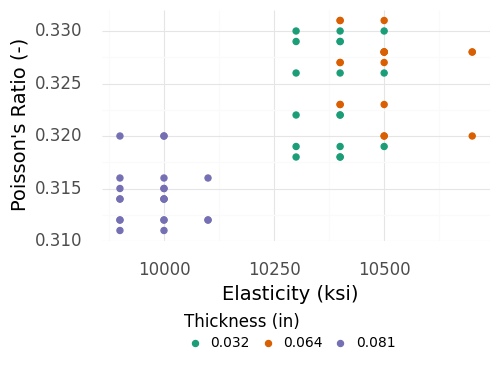

In [3]:
%%capture --no-display
# Hide cell
from grama.data import df_stang

p = (
    df_stang
    >> gr.tf_filter(DF.thick != 0.022)
    >> gr.tf_mutate(thick=gr.as_str(DF.thick))
    >> gr.ggplot(gr.aes("E", "mu", color="thick"))
    + gr.geom_point(size=2)
    + gr.scale_color_brewer(name="Thickness (in)", type="qual", palette=2)
    + gr.theme_uqbook()
    + gr.labs(
        x="Elasticity (ksi)",
        y="Poisson's Ratio (-)",
    )
)
print(p)

```{glue:figure} unc-vis-alloys
:name: fig-unc-vis-alloys

Material property values measured for several aluminum plates of different thicknesses. Note that the thickest plates tend to have much lower Poisson's Ratio and Elasticity values.
```

Because elasticity and Poisson's ratio are often assumed to be material properties---independent of part thickness---it is surprising to see the thickest samples with property values well-separated from the thinner specimens. These data exhibit both chance and assignable causes:

- The $0.081$ inch-thick specimens are well-separated from the other observations. By reviewing the original publication reporting these data, we can tell that the thickest specimens were tested using a different measurement technique, providing an assignable cause for the variability between the $0.081$ inch and thinner observations {cite}`stang1946`.
- The remaining thinner specimens are tightly-grouped, but do not have identical values. We have no other explanations available for this variability, so we ought to treat this as chance cause.


```{tip} **Treating chance and assignable causes**
If you suspect that an uncertainty has an assignable cause, conduct additional studies to find, explain, and hopefully control that cause of uncertainty. If you suspect that an uncertainty cannot be practically reduced and it is sufficiently regular to treat as random, then fit a distribution to describe that uncertainty.
```

### Dichotomy: Real and erroneous sources
```{index} single: uncertainty ; source
```

A distinction between *real and erroneous sources* of uncertainty is made in the statistics education community {cite}`wild1999statistical`. Put simply, real sources affect the quantity we are trying to study, while erroneous sources corrupt measurements of our quantity of interest. A more formal definition involves a bit of nomenclature [^altSource].

[^altSource]: There are alternative conceptual frameworks of uncertainty. For instance, uncertainty is sometimes described as *aleatory* or *epistemic* {cite}`der2009aleatory`. However, uncertainties can be both aleatory and epistemic and there is open conflict in the literature about when each category applies {cite}`der2009aleatory,morgan2017theory`. 

```{index} single: modeling ; quantity of interest
```
QOI and Measurement
: Our *quantity of interest* (QOI) is the quantity we seek to record, while the *measurement* is the value we actually record.

The following figure schematically illustrates the QOI and measurement in a simple scenario with two chance-cause uncertainties. You can think of real uncertainties as occurring "before" the QOI is generated, and erroneous uncertainties as occurring "after" the QOI. **{numref}`Figure %s <fig-unc-noise-deviation>`** depicts a QOI that is affected by one real source and one erroneous source of uncertainty.


:::{figure-md} fig-unc-noise-deviation
<img src="../images/noise-v-deviation.png" alt="A schematic depiction of real and erroneous uncertainty." width="75%">

Schematic depiction of a scenario with sources of both erroneous (noise) and real (deviations) uncertainty. The chosen quantity of interest (QOI) is measured imperfectly, represented by the distribution to the right that results in a measurement. However, the QOI itself has no single "true value;" there are deviations in the QOI that cannot be eliminated. In this sense, the QOI exhibits real variability.
:::

In {numref}`Figure %s <fig-unc-noise-deviation>`, the quantity of interest is inherently uncertain, as represented by the left-most distribution (bell-shaped curve). Since the QOI does not take a single fixed value, it is said to exhibit real variability. However, our measurement of that QOI is also subject to noise, as represented by the right-most distribution. This measurement noise is one form of erroneous uncertainty.

As noted in {numref}`Chapter %s <01-modeling-process>`, you are responsible for *choosing* your QOI. This requires a strong domain-specific understanding of the problem at hand: Only you can decide what quantity is worth studying in your particular application!

```{warning} **Not all QOIs are equal!**
In {numref}`Section %s <02s-propagation-concepts>` we will see how a poor choice of QOI has led to errors in aircraft design that have persisted for decades and have negatively impacted safety. 
```

Distinguishing between the QOI and measurement helps us understand the *consequences* of a source of uncertainty, as captured in the next definition.

```{index} seealso: real ; uncertainty ; source
```
```{index} seealso: erroneous ; uncertainty ; source
```
Real and erroneous sources
: An uncertainty is said to be a *real source* if it affects our QOI, while it is said to be an *erroneous source* if it only affects our measurement.

Put differently, real uncertainty affects the quantity we seek to study, while erroneous uncertainty corrupts the value we manage to record. This dichotomy helps us understand the consequences of different sources of uncertainty.

```{warning} **Neglecting real uncertainty can lead to fatal accidents.**
Real uncertainty has real consequences! An example from aerospace design illustrates this reality: Before the 1950s, military aircraft were designed to accommodate "the average man," with seats and controls sized for average male dimensions {cite}`daniels1952average`. As the U.S. Air Force transitioned to jet aircraft, they found that pilots were unable to control their aircraft. At the height of this calamity, 17 aircraft crashed in a single day {cite}`rose2016end`. 

While the Air Force initially blamed their pilots for being incapable of handling the new jet technology, the researcher Gilbert Daniels thought to ask a simple question: "How many of our pilots are average?" Strikingly, Daniels found that, out of 4,063 pilots, *precisely zero* were average! The real variability in pilot dimensions---height, arm length, leg length, etc.---led to different needs for effective piloting of the aircraft. In designing their aircraft for "the average man," the Air Force had designed them for no one.

The solution to this issue was to confront uncertainty directly: The Air Force banned the use of the average for aircraft interface design and instead required seats to be made adjustable to accommodate all their pilots. From a design perspective, they stopped specifying designs using a single value (the mean) and instead defined a range of values. This confrontation with of real variability eliminated the problem and led to safer aircraft design.
```


Erroneous uncertainty can also be due to limited data collection. We might be able to carry out the desired measurements in principle, but if we only observe a fraction of the possible values, then this leads to *sampling error*.

```{tip} **Real and Erroneous variability in manufacturing.**
When manufacturing structural components to resist fatigue, there are both real and erroneous sources of uncertainty. The proper QOI when studying the fatigue of structural components is the *realized* strength of each component. As discussed previously, the presence of cracks in a part will affect fatigue strength, which will in turn affect our QOI and create real uncertainty. However, while we can manufacture an unlimited number of components, we can only test a limited fraction. Limited testing gives rise to sampling error.
```

Distinguishing between real and erroneous sources is important for both data collection and analysis.

```{tip} **Treating real and error sources in data collection.**
If you believe that your scenario is affected by real uncertainty, then you should prepare and characterize multiple specimens according to the same specifications. If you believe that your measurements are affected by sources of error, then you should take multiple measurements on each specimen. If you have a mix of real and erroneous sources, then you should prepare multiple specimens and measure each one multiple times [^nested].
```

[^nested]: In statistics, this is called a "nested design of experiment" {cite}`ryan2007doe`.

## The Cause-Source Quadrants

The cause and source dichotomies serve as independent axes. Using these as orthogonal axes yields the *cause-source quadrants*, shown in **{numref}`Figure %s <fig-unc-quadrants>`**. Each quadrant can be given a descriptive name: *noise, deviation, anomaly,* and *mistake*.

:::{figure-md} fig-unc-quadrants
<img src="../images/cause-source-quadrants.png" alt="The four quadrants of uncertainty." width="75%">

The cause and source dichotomies form quadrants of uncertainty.
:::

To learn how to recognize each of the quadrants, it is helpful to consider the pairwise distinctions across each axis:

- **Noise vs. Deviation:** Both noise and deviation are treated as random, but deviations affect the quantity we seek to study, while noise corrupts our measurements.

- **Noise vs. Mistake:** Both noise and mistakes corrupt a measurement, but noise is treated as random, while a mistake has an assignable cause.

- **Deviation vs. Anomaly:** Both deviations and anomalies are real, but deviations are treated as random, while an anomaly has an assignable cause.
  
- **Anomaly vs. Mistake:**  Both anomalies and mistakes have assignable causes, but anomalies affect the quantity we seek to study, while mistakes corrupt our measurements.

### Example: Cause and source in metals manufacturing
```{index} single: examples ; manufacturing uncertainties
```

To help make the cause and source dichotomies clear, let's consider a specific example that illustrates examples from all four cause-source quadrants. **{numref}`Figure %s <fig-unc-mfg-example>`** depicts stages in the manufacture and testing of a metallic alloy. The quantity of interest is the *as-manufactured* fatigue strength of the parts. Uncertainty can enter in each of the four stages.

:::{figure-md} fig-unc-mfg-example
<img src="../images/manufacturing-examples-numbered.png" alt="An example in manufacturing exhibiting all four quadrants of uncertainty." width="95%">

An example in the manufacture of a metallic alloy that exhibits all four quadrants of uncertainty.
:::

:::{figure-md} fig-unc-mfg-real-assignable
<img src="../images/1-real-assignable.png" alt="An example of real, assignable uncertainty." width="50%">

Anomaly: An example of real, assignable uncertainty.
:::

#### Stage 1: Anomaly: Real source, assignable cause

Here a worker has accidentally added contaminating materials during the manufacture of an alloy (**{numref}`Figure %s <fig-unc-mfg-real-assignable>`**). These contaminants alter the composition of the alloy, leading to uncertainty in its material properties. The source is real, as the contaminants will certainly affect the performance of materials made with this corrupted batch of metal, including the fatigue strength. The cause is assignable, as we can both identify and avoid this cause of uncertainty in the future.

:::{figure-md} fig-unc-mfg-real-chance
<img src="../images/2-real-chance.png" alt="An example of real, chance uncertainty." width="50%">

Deviation: An example of real, chance uncertainty.
:::

#### Stage 2: Deviation: Real source, chance cause

During the cooling and shaping of metal ingots, nicks and cracks will inevitably form (**{numref}`Figure %s <fig-unc-mfg-real-chance>`**). The presence and size of these cracks will affect the fatigue strength of the material. This is an unavoidable reality of manufacturing, as it is impossible to guarantee that all parts will be $100\%$ free of flaws. The source is real, as these small defects cause uncertainty in the properties of manufactured components. The cause is chance, as it is impractical to completely eliminate these small defects.

:::{figure-md} fig-unc-mfg-error-assignable
<img src="../images/3-error-assignable.png" alt="An example of erroneous, assignable uncertainty." width="50%">

Mistake: An example of erroneous, assignable uncertainty.
:::

#### Stage 3: Mistake: Erroneous source, assignable cause

Once a material is manufactured, we must carry out physical tests to quantify its material properties (**{numref}`Figure %s <fig-unc-mfg-error-assignable>`**). However, errors can occur during this testing process that mis-characterize the material properties. Here we see that the test fixture holding a part has slipped during mechanical testing, leading to an error in the fatigue strength measured in this test. The source is erroneous, as the slipping of a grip during testing would not affect the behavior of the material in its intended application. The cause is assignable, as we could eliminate this error by altering the test fixture.

:::{figure-md} fig-unc-mfg-error-chance
<img src="../images/4-error-chance.png" alt="An example of erroneous, chance uncertainty." width="50%">

Noise: An example of erroneous, chance uncertainty.
:::

#### Stage 4: Noise: Erroneous source, chance cause

Often in mechanical tests, physical phenomena are converted to electrical signals by way of a sensor (**{numref}`Figure %s <fig-unc-mfg-error-chance>`**). In mechanical tests, a strain gauge is used to convert elongation into an electrical signal carried on a wire. However, radio waves in the environment can corrupt this signal, affecting the recorded fatigue strength. The source is erroneous, as this electrical noise does not change the real material properties. The cause is chance, as it may not be practical to completely eliminate ambient electrical noise.

### Making use of nature, cause, and source

The nature, cause, and source dichotomies are independent axes intended to help you make informed decisions in the modeling process.

*Nature* determines where in your model a particular uncertainty occurs: in the parametric inputs or the form of the model.

*Cause* determines what high-level strategy you will pursue for a particular uncertainty: seek additional information (assignable cause) or represent it as a simple source of randomness (chance cause).

*Source* determines how to analyze a particular uncertainty: summarize multiple observations to produce a better measurement (erroneous source) or propagate / quantify extreme values of the uncertainty (real source).


## Special Cases of Uncertainty

The following are special cases of uncertainty. *Sampling uncertainty* is a form of erroneous uncertainty that arises due to limited data. *Variability* is a core idea from statistics.


### Sampling uncertainty
```{index} seealso: sampling ; uncertainty ; source
```

Sampling---in a statistical sense---refers to a kind of planned data collection. Generally, we will only have access to a subset of the data that we could potentially collect---this creates an erroneous source of uncertainty known as *sampling uncertainty*. We will discuss sampling uncertainty in {numref}`Section %s <02s-estimation>`.

### Variability
```{index} single: uncertainty ; variability
```

Variability is the phenomenon of non-identical values, which clearly gives rise to uncertainty. Understanding variability is the primary goal of statistical inquiry. The statistics educators {cite:t}`wild1999statistical` described the importance and character of variability well in their statement,

> Variation is an observable reality. It is present everywhere and in everything. Variability affects all aspects of life and everything we observe. No two manufactured items are identical, no two organisms are identical or react in identical ways. 

We use the following definition for variability.

Variability
: *Variability* is a form of uncertainty that occurs when multiple measurements exhibit different outcomes.

Trivially, we must have *different* outcomes for there to be variability. If repeated measurements of the same quantity produce the same value, then there is no variability. In order to observe different outcomes, we must take multiple measurements. Uncertainty about a value that we cannot measure is not variability.


While statistical inquiry seeks to explain variability, much of what is observed is *unexplained variability*. Unexplained variability has a more restricted definition.

Unexplained variability
: *Unexplained variability* is a form of uncertainty that occurs when repeated measurements from a *single, chosen scenario* exhibit different outcomes.

Unexplained variability arises when we focus on a *single* scenario and take repeated measurements. Studying different scenarios means we should not expect measurements to come out the same---the different scenarios explain the variability. We might describe a scenario in terms of detailed qualitative factors (e.g. a single manufacturer) or we may index a family of scenarios with continuous variables (e.g. a continuum of feed speeds when machining).

For instance, if we expect that an outcome $y$ tends to vary with an input $x$ as $y = x^2$, then we would not consider changes as we vary $x$ to be unexplained variability, but rather a deterministic trend (i.e., a fully predictable input-to-output behavior). However, we often observe a mixture of unexplained variability and trends, as shown in **{numref}`Figure %s <fig-unc-vis-trend>`**.


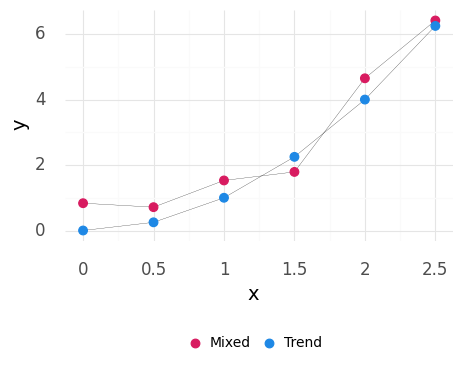

In [4]:
%%capture --no-display
# Hidden cell input
np.random.seed(102)
n = 6
p = (
    gr.df_make(x=range(0, n))
    >> gr.tf_mutate(x = DF.x / 2)
    >> gr.tf_mutate(
        y_Trend=DF.x**2,
        y_Mixed=DF.x**2 + np.random.normal(size=n, scale=0.5),
    )
    >> gr.tf_pivot_longer(
        columns=["y_Trend", "y_Mixed"],
        names_to=(".value", "type"),
        names_sep="_",
    )
    >> gr.ggplot(gr.aes("x", "y", group="type"))
    + gr.geom_line(size=0.1)
    + gr.geom_point(gr.aes(color="type"), size=3)
    + gr.scale_color_manual(
        name=" ",
        values={"Mixed": gr.qual1, "Trend": gr.qual2},
    )
    + gr.theme_uqbook()
)
print(p)

```{glue:figure} unc-vis-trend
:name: fig-unc-vis-trend

Example distinguishing between a deterministic trend and a mixture of a trend with unexplained variability.
```

For variability to be unexplained the scenario must be *chosen*: Unexplained variability is often caused by changes to the scenario that are *not chosen*. *Lurking variables*---unknown inputs---can fluctuate and lead to unexplained variability. In principle, such an unknown variable might be controllable and predictive of the observed variability (like $x$ in $y = x^2$). Identifying and controlling a lurking variable may reduce the observed variability---providing an explanation for the previously unexplained variability. But until we are aware of such an unknown factor, the differing measurements are unexplained variability. 


```{admonition} **Manufacturing line example.**
Components of the same material and processing method on a manufacturing line would be expected to have *similar* but not *identical* performance. This manufacturing line would constitute a chosen scenario. Different parts, different materials, or different processing methods would constitute different scenarios, and thus we would not describe measurement differences attributed to these different scenarios as unexplained variability.
```

Unexplained variability can only be detected through repeated measurement of the same chosen scenario.

```{warning} **Unexplained variability necessitates multiple observations!**
If there is unexplained variability in your chosen scenario, this implies that you should collect *repeated observations from the same scenario* to inform your modeling. Modeling techniques such as fitting distributions require multiple observations.
```

## Making Decisions Under Uncertainty

Once we have identified the uncertainties in our problem we can use this information to help make decisions. We discuss two important types of decisions: planning data collection and targeting uncertainty.

### Planning data collection

For a given physical system, a conceptual understanding of uncertainty directly influences the planning of data collection on that system. Planning data collection is a subfield of statistics called *design of experiments* {cite}`ryan2007doe`, which is outside the scope of this book. However, the ideas above serve as useful heuristics for planning data collection.

*Variability*. The presence of variability requires that more than one measurement. To detect unexplained variability, multiple measurements must be conducted for the same scenario. Ideas from sampling theory (See {numref}`Section %s <02s-estimation>`) can help determine an appropriate number of measurements.

*Nature*. With a parametric uncertainty, multiple measurements should be carried out at the same conditions. However, with a model-form uncertainty, multiple measurements should be "spaced out" to help inform a functional form for modeling.

*Cause*. The framework of chance and assignable cause was developed to help plan data collection and find assignable causes. Using ideas from statistical process control can help with planning and analyzing data in a way that can identify assignable causes (see {numref}`Appendix %s <04s-control-charts>`).

*Source*. The concepts of real and erroneous source can help determine which measurements to take. A source of erroneous uncertainty requires multiple measurements *on the same specimen* to characterize. A source of real uncertainty requires multiple measurements *on multiple specimens* to characterize. Generally, physical systems exhibit both real and erroneous uncertainties, which leads to a *nested* experimental design {cite}`box1978statistics`.

(02-targeting)=
### Targeting uncertainty
```{index} single: uncertainty; targeting
```

When uncertainty cannot be eliminated or reduced, one must make decisions to address the remaining uncertainty. One way to frame this is through **targeting uncertainty** {cite}`zdr2023nsf`. When targeting uncertainty, one considers the possible negative consequences associated with different plausible values for an uncertain quantity. Then, one chooses to take action that will mitigate those negative consequences.

The simple idea behind targeting manifests in different ways, depending on the context. For instance, some uncertain values have *one-sided* consequences---negative outcomes occur only for extreme values (large or small). **{numref}`Figure %s <fig-unc-target-lo>`** illustrates one such scenario, where small values lead to negative consequences.

:::{figure-md} fig-unc-target-lo
<img src="../images/nat-responses-lo.png" alt="" width="60%">

Targeting uncertainty with one-sided negative consequences: selecting a lower value.
:::

However, some scenarios have *two-sided* consequences---negative outcomes occur at both high and low values (**{numref}`Figure %s <fig-unc-target-range>`**). In this case, one must plan for both possibilities. One- and two-sided scenarios are not the only possibilities; in practice, you must use your own domain-specific knowledge of the problem to determine what values would lead to negative consequences.

:::{figure-md} fig-unc-target-range
<img src="../images/nat-responses-range.png" alt="" width="60%">

Targeting uncertainty with two-sided negative consequences: designing for a range.
:::

What constitutes targeting will depend on the modeling question at hand, particularly whether the *action* will be direct or rhetorical ({numref}`Chapter %s <01-modeling-process>`). For instance, in a two-sided scenario, a design team taking direct action may need to design mechanisms to accommodate the variability that may occur in practice. For instance, automobiles have adjustable seats to accommodate the variability across drivers, including different heights, different arm lengths, etc. 

In a two-sided scenario involving rhetorical action, it may be necessary to impress upon external parties the importance of a range. For instance, for crash safety purposes, it is necessary that the structural material used in the car's frame be sufficiently strong to withstand everyday use, but not so strong that it cannot crumple and absorb impact. Automobile manufacturers actually specify both a lower and upper bound for strength from their material suppliers, for just this reason.

## Conceptual Analysis of Case Studies

To help solidify the concepts in this section, let's take a look at a few different case studies. Each case is framed in terms of a modeling question and a specified quantity of interest. These contextual elements are required to categorize all uncertainties according to their nature, cause, and source.


### Vaccine efficacy

*Question*: What is the efficacy of a virus-targeting vaccine, measured by comparing the percentage of treated individuals who are not infected by the virus against a control?

*Quantity of interest*: Vaccine efficacy across the full adult US population with members in full health, given the as-manufactured vaccine.

*Decisions*: The standard practice (in the U.S.) in this kind of scenario is to use a phased approach to data collection {cite}`nih-facts`. The earliest phases involve small numbers of participants, in order to test for safety and side effects. Later phases involve large, representative samples of the target patient population. Random selection of patients is used to promote inference to the full population, while random assignment to receive the drug (treatment) or a placebo (control) is used to help determine if it was the vaccine that actually caused a change in outcomes {cite}`cobb2007introductory`.

**{numref}`Table %s <tab-ex-vacc-efficacy>`** lists uncertainties in this example, along with their type (nature, cause, and source).

```{table} Uncertain factors in the vaccine efficacy example.
---
name: tab-ex-vacc-efficacy
---
| **Uncertainty** | **Nature** | **Cause** | **Source**  |
|-----------------|--------|------------|---------|
| Entry error     | Parametric | Assignable | Erroneous |
| Finite sample   | Parametric | Chance     | Erroneous |
| Biased sample   | Parametric | Assignable | Erroneous |
| Comorbidities   | Model-form | Chance     | Real    |
| Manufacturing error | Parametric | Assignable | Real    |
```

*Entry error*: Vaccine status is recorded via paper records. A data-entry error could mistakenly record the wrong assignment (treatment rather than placebo), which would affect our conclusions, but not the vaccine efficacy. Type of uncertainty: parametric, assignable, erroneous. 

*Finite sample*: The full adult US population includes millions of people, but testing a vaccine on the whole population is not feasible. Practically, a subset of the full population must be chosen for testing; this constitutes our sample. Carefully designing this sample helps to mitigate various forms of uncertainty. For instance, treatment assignment is done randomly, as this guarantees that this uncertainty is chance (and not due to any assignable cause). Type of uncertainty: parametric, chance, erroneous. 

*Biased sample*: Our QOI considers the full adult US population; if our sample over-represents high-income individuals, this would be a biased sample. As income is well-correlated with health outcomes, this would affect our *measurement* of the efficacy, but would not change the efficacy for the desired population. Type of uncertainty: parametric, assignable, erroneous.

*Comorbidities*: No two adults have an identical health status. Individuals tend to have *comorbidities*, the simultaneous presence of multiple diseases. Because the presence of any disease varies over time, and a comorbidity can affect the infectiousness of a disease, comorbidities will affect the efficacy of the vaccine in the target population. Type of uncertainty: model-form, chance, real. 

*Manufacturing error*: If doses of the vaccine are incorrectly manufactured---say, have half the desired dosage---then the treatment will likely be less effective than intended. Because our QOI considers the vaccine *as-manufactured* and not *as-designed*, this manufacturing error will affect our QOI. Type of uncertainty: parametric, assignable, real. 


### Wind energy farm

*Question*: What is the amount of power generated daily by an installation of multiple wind turbines (a "wind farm"), making predictions using a low-fidelity physics-based model?

*Quantity of interest*: The total power generation of the wind farm on a given day.

*Decisions*: This particular scenario does *not* include any analysis of emissions, as any implementation of the system will tend to reduce emissions (See {numref}`Chapter %s <01-modeling-process>`). In this case, applying the idea of targeting uncertainty reveals that there are *no* consequences of system emissions on the outcomes in this scenario.

**{numref}`Table %s <tab-ex-windfarm>`** lists uncertainties in this example, along with their type (nature, cause, and source).

```{table} Uncertain factors in the wind energy farm example.
---
name: tab-ex-windfarm
---
| **Uncertainty** | **Nature** | **Cause** | **Source** |
|-----------------|--------|------------|---------|
| Aerodynamic model | Model-form | Assignable | Erroneous |
| Wind conditions | Parametric | Chance     | Real    |
| Discrepancy     | Model-form | Chance     | Erroneous |
```

*Aerodynamic model*: Simulating an entire wind farm is likely to be too computationally intensive to model with the highest-fidelity aerodynamic models available. This means that reasonable approximations to the physics must be made in the name of computational tractability. Because our QOI considers the physical power generated, this choice of model cannot affect our QOI. Type of uncertainty: model-form, assignable, erroneous.

*Wind conditions*: To simulate performance on any day, we must have the ambient flow conditions as inputs for the physics-based model. Weather is currently not perfectly predictable, especially far in advance. The real weather conditions will determine the physical power generated. Type of uncertainty: parametric, chance, real. 

*Discrepancy*: As our model is imperfect, even if we were to do a retrospective calculation using the as-measured wind conditions and true power generated, the predicted and actual values would not match. Because it is not practical to improve the aerodynamic model further, we might choose to treat this remaining discrepancy as a random process. Type of uncertainty: model-form, chance, erroneous.



### Piston cycle time

*Question*: What is the cycle time for a particular internal combustion engine (ICE) in an environment-controlled lab targeting standard temperature and pressure (STP)?

*Quantity of interest*: ICE cycle time in a controlled lab at STP.

*Decisions*: In this scenario, the uncertainty in the cycle time helps set our expectations when comparing predictions against measured values, and can help us make decisions about where to seek improvement. If the erroneous uncertainties lead to unacceptably large uncertainty in the cycle time, then we can impose stricter environmental controls (for the ambient conditions) or design more reliable instrumentation (to reduce the effects of switch bounce). If the uncertainty in the fuel-air mix is a large contributor to output uncertainty, it may mean that a redesign of the engine is necessary to mitigate this effect. 

Ultimately, there will always remain some nonzero uncertainty in the piston cycle time. For this reason, any downstream mechanism that relies on this engine must be designed to accommodate the possible variation in cycle time; designing for this range will target the uncertainty in the system.

**{numref}`Table %s <tab-ex-piston>`** lists uncertainties in this example, along with their type (nature, cause, and source).

```{table} Uncertain factors in the piston cycle time example.
---
name: tab-ex-piston
---
| **Uncertainty** | **Nature** | **Cause** | **Source** |
|-----------------|--------|------------|---------|
| Ambient conditions | Parametric | Assignable | Erroneous |
| Fuel-air mix    | Parametric | Assignable | Real    |
| Switch bounce   | Parametric | Chance     | Erroneous |
```

*Ambient conditions*: If ambient conditions depart from STP, then the measured cycle time will biased away from the value we are attempting to measure. Type of uncertainty: parametric, assignable, erroneous.

*Fuel-air mix*: The fuel-air mixture will certainly affect the cycle time, but was left unspecified in the initial description above. If left unconsidered, the fuel-air mix will not be tightly controlled and may cause additional variability. This oversight would quickly be identified, a desired fuel-air mixture decided upon, and the source of variability eliminated. Type of uncertainty: parametric, assignable, real. 

*Switch bounce*: Mechanical switches are spring-operated and will tend to "bounce" when depressed. This creates a fluctuating waveform that must be processed to identify the "true" time at which the switch was thrown. This processing is usually done with simple assumptions rather than detailed modeling of the switch. Type of uncertainty: parametric, chance, erroneous.

